In [104]:
from PIL import Image
import os
import cv2
from matplotlib import pyplot as plt

image_file = os.path.join(os.getcwd(),'data/task_menu_1.png')
im = Image.open(image_file)
print(im)
image = cv2.imread((image_file))
# im.show()

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=981x1100 at 0x23B701362C0>


In [2]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

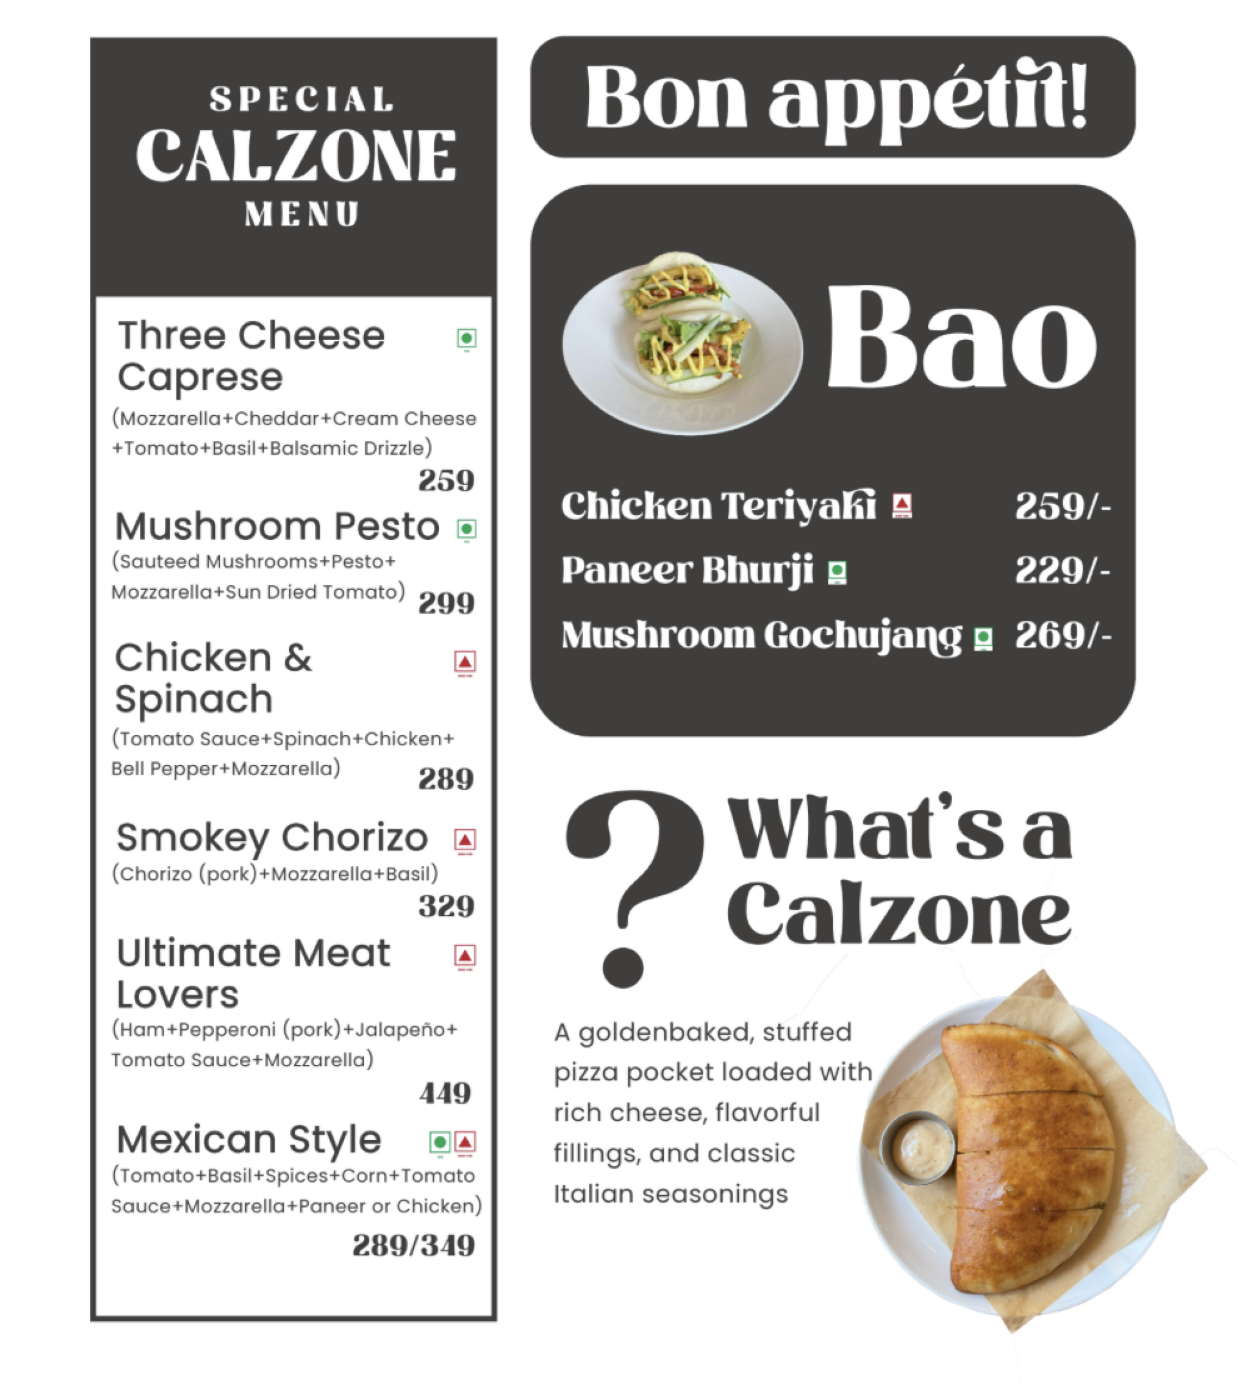

In [3]:
display(image_file)


## Binarization


In [4]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)

In [ ]:
grey_image = grayscale(image)
cv2.imwrite("temp/task_menu_1_gray.png", grey_image)

True

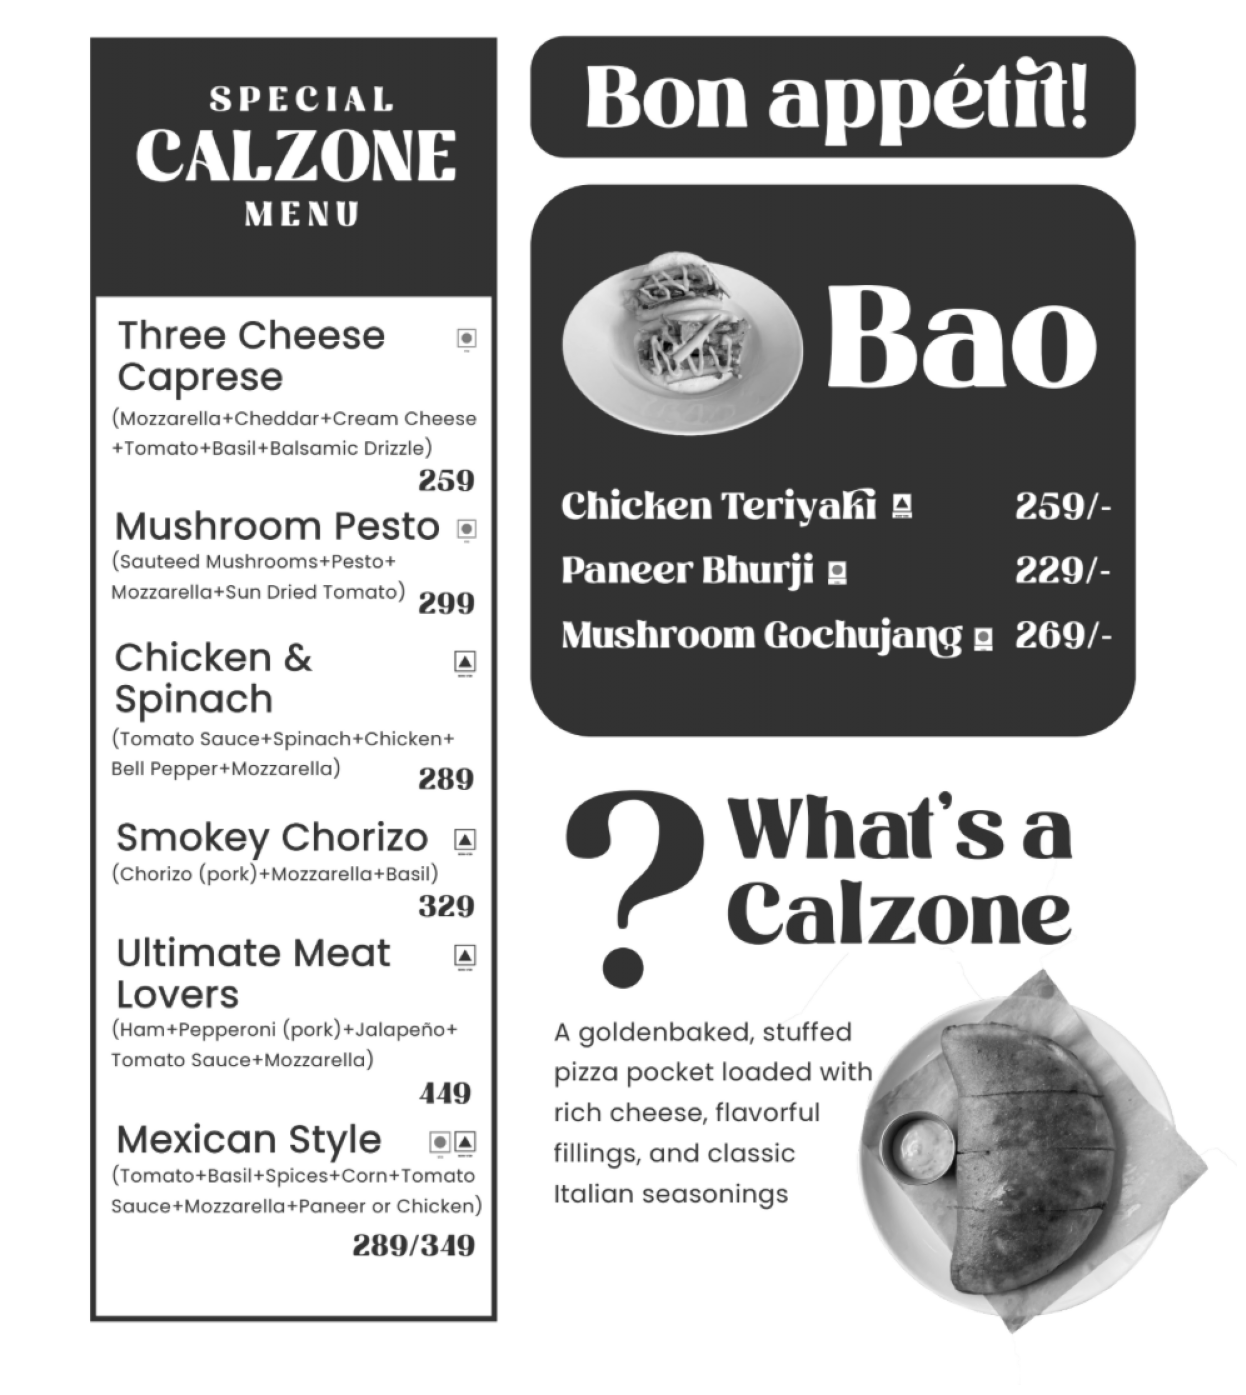

In [6]:
display("temp/task_menu_1_gray.png")

## Inverted Image

In [7]:
inverted_image = cv2.bitwise_not(grey_image)
cv2.imwrite("temp/inverted_task_menu_1.png", inverted_image)

True

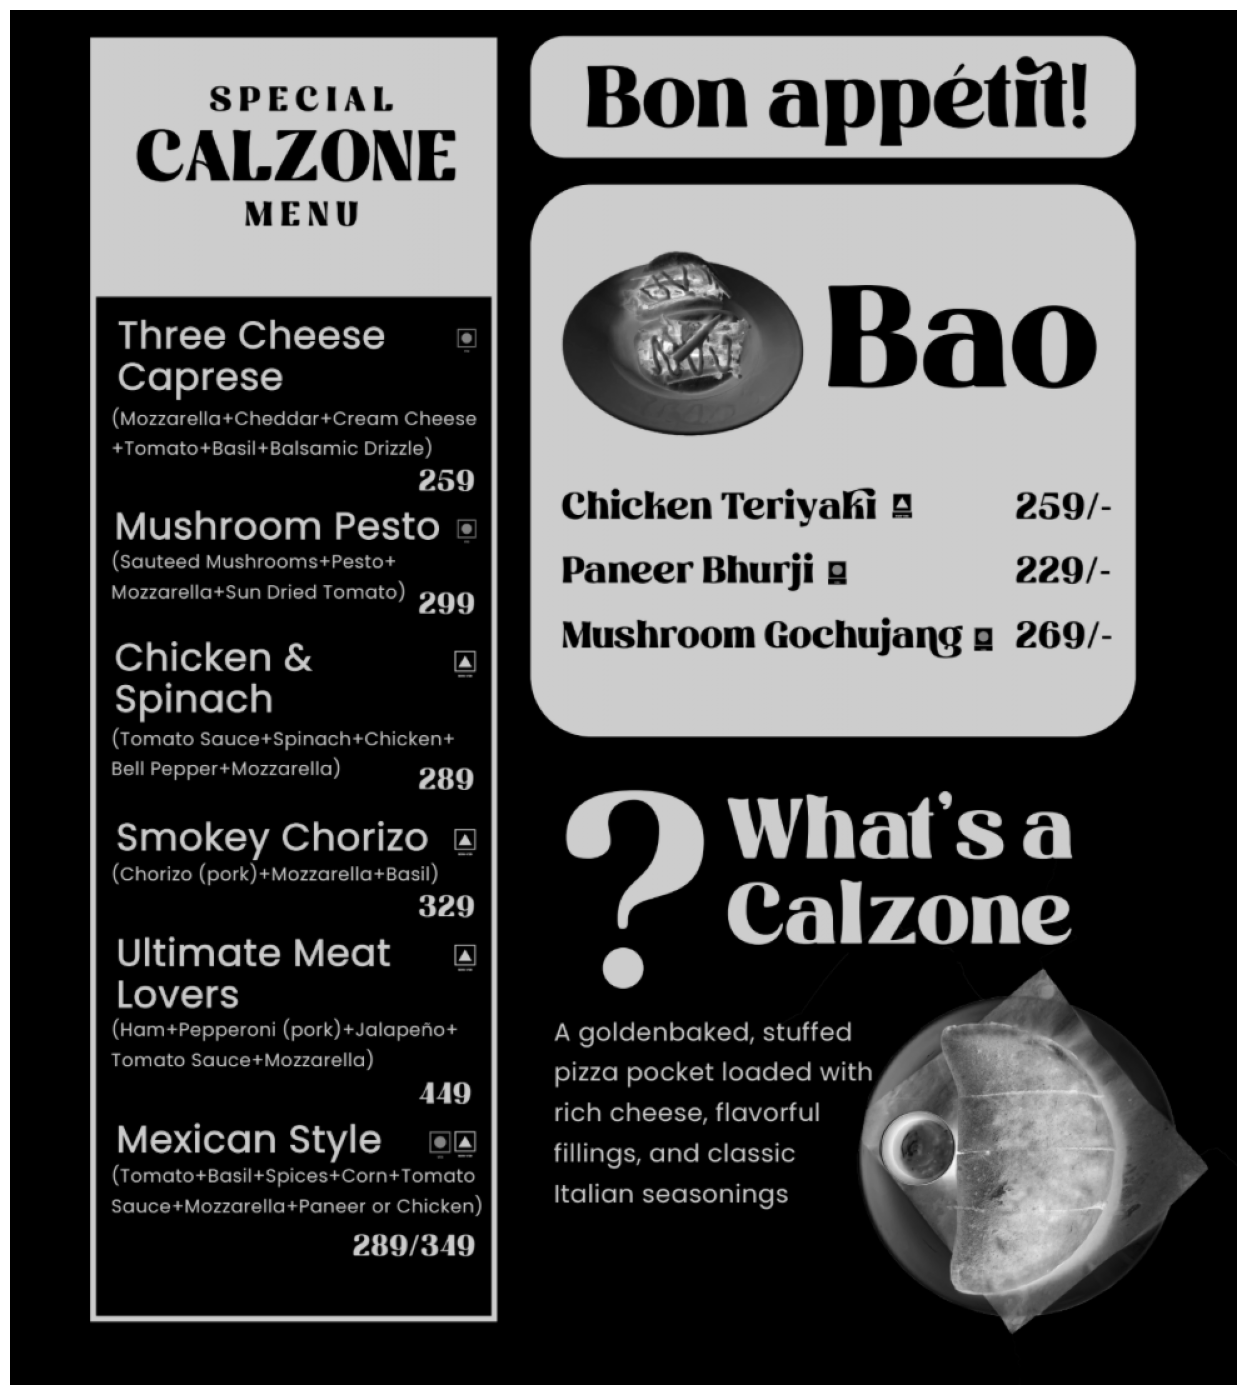

In [8]:
display("temp/inverted_task_menu_1.png")

## Noise Removal

In [9]:

def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return (image)

In [10]:
no_noise = noise_removal(grey_image)
cv2.imwrite("temp/no_noise_task_menu_1.png", no_noise)


True

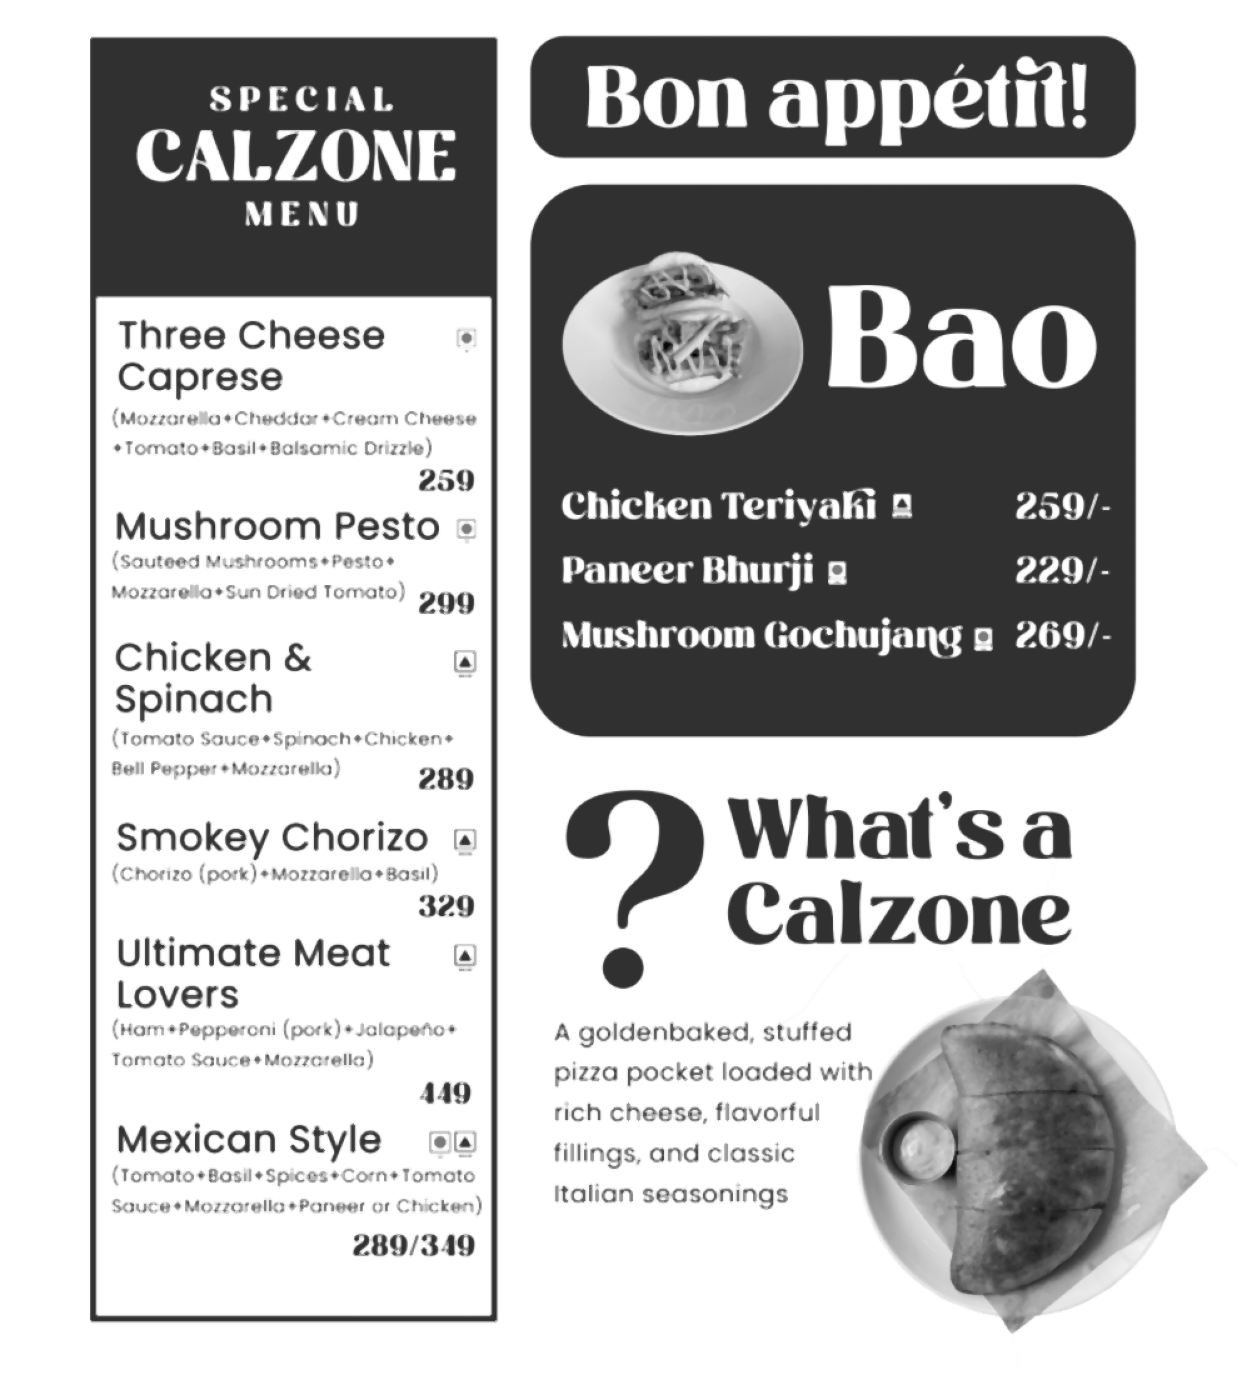

In [11]:
display("temp/no_noise_task_menu_1.png")

## OCR

In [14]:
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"  # Windows


In [17]:
ocr_result = pytesseract.image_to_string(grey_image)
print(ocr_result)

SPECIAL

CALZONE

MENU

Three Cheese
Caprese

(Mozzarella+Cheddar+Cream Cheese
+Tomato+Basil+Balsamic Drizzle)
259
Mushroom Pesto ©
(Sauteed Mushrooms+Pesto+
Mozzarella+Sun Dried Tomato) 299

Chicken & ry

Spinach

(Tomato Sauce+Spinach+Chicken+

Bell Pepper+Mozzarella) 289

Smokey Chorizo @

(Chorizo (pork)+Mozzarella+Basil)

329

Ultimate Meat @
Lovers

(Ham+Pepperoni (pork)+Jalapenio+
Tomato Sauce+Mozzarella)

449
Mexican Style @a@

(Tomato+Basil+Spices+Corn+Tomato
Sauce+Mozzarella+Paneer or Chicken)

289/349

Chicken Teriyaki 2 259/-

Paneer Bhurji 2 229/-
Mushroom Gochujang 2 269/-

A goldenbaked, stuffed
pizza pocket loaded with
rich cheese, flavorful
fillings, and classic
Italian seasonings



In [18]:
ocr_result = pytesseract.image_to_string(inverted_image)
print(ocr_result)

SPECIAL

CALZONE

MENU

Three Cheese
Caprese

(Mozzarella+Cheddar+Cream Cheese
+Tomato+Basil+Balsamic Drizzle)
259
Mushroom Pesto
(Sauteed Mushrooms+Pesto+
Mozzarella+Sun Dried Tomato) 299

Chicken & ry

Spinach

(Tomato Sauce+Spinach+Chicken+

Bell Pepper+Mozzarella) 289

Smokey Chorizo @

(Chorizo (pork)+Mozzarella+Basil)

329

Ultimate Meat @
Lovers

(Ham+Pepperoni (pork)+Jalapefio+
Tomato Sauce+Mozzarella)

449
Mexican Style @a@

(Tomato+Basil+Spices+Corn+Tomato
Sauce+Mozzarella+Paneer or Chicken)

289/349

Chicken Teriyaki 2 259/-

Paneer Bhurji 2 229/-
Mushroom Gochujang 2 269/-

A goldenbaked, stuffed
pizza pocket loaded with
rich cheese, flavorful
fillings, and classic
Italian seasonings



This is multicolumnar data, so not accurate. I'll create bouding boxes to seperate each column. App

In [130]:
gray = gray = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)


blur = cv2.GaussianBlur(gray, (5,5), 0)


In [131]:
cv2.imwrite("temp/index_blur.png", blur)


True

In [132]:
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cv2.imwrite("temp/index_thresh.png", thresh)


True

In [134]:
cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])
results  = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    if h > 200 and w > 20:
        roi = image[y:y+h, x:x+h]
        cv2.rectangle(image, (x, y), (x+w, y+h), (36, 255, 12), 2)
        ocr_result = pytesseract.image_to_string(roi)
        ocr_result = ocr_result.split("\n")
        for item in ocr_result:
            results.append(item)
cv2.imwrite("temp/index_bbox_gray.png", image)

True

In [137]:

# OCR each column
ocr_results = []
for col in results:
    pil_img = Image.fromarray(col)
    text = pytesseract.image_to_string(pil_img, lang="eng")
    ocr_results.append(text)

# Join results, split lines, and extract candidate named entities
all_text = "\n".join(ocr_results)
lines = all_text.split('\n')
candidates = []
for line in lines:
    cleaned = line.strip()
    if cleaned and cleaned.isupper():  # Basic rule, refine as needed
        candidates.append(cleaned)

# Deduplicate, preserving order
seen = set()
entities = []
for name in candidates:
    if name not in seen:
        seen.add(name)
        entities.append(name)

# Print result
for entity in entities:
    print(entity)

AttributeError: 'str' object has no attribute '__array_interface__'